# TP - Recalage d'images - Notebook et rapport

Tristan Hoellinger\
M1 Mathématiques Appliquées, Insa Toulouse\
janvier 2021

## Importations

In [39]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import numpy.linalg as npl
from scipy import signal
from scipy import interpolate
import PIL 
import matplotlib.pyplot as plt

import sys
sys.path.append('src/')
import Recalage as lib
from utils import results, plot_results, obj_vs_lam, plot_curves

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Introduction

In this practical (in French), we propose a very simple model of image registration. The goal is to find a "good" transformation $T$ such that $T(I_1) \approx I_2$. We will use the mean squared error as a metric to compare the two images.

Nous commençons par charger deux images synthétisées `f` et `g` qui sont essentiellement translatées l'une de l'autre.

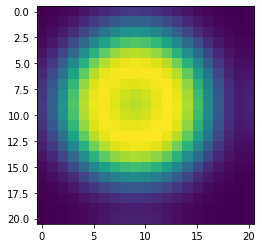

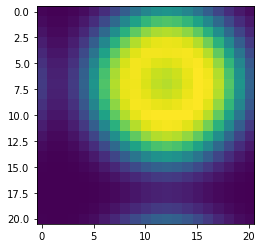

In [5]:
f,g,(X,Y)=lib.getGaussians()
plt.imshow(f)
plt.show()
plt.imshow(g)
plt.show()

## 1. Formalisation du problème

 ### 1.1 Formalisme continu

On modélise les images en niveaux de gris comme des fonctions d’un ensemble borné $\Omega\subset \mathbb{R}^2$ (typiquement un carré) dans $\mathbb{R}$. La valeur de la fonction en chaque point représente l’intensité lumineuse de l’image. 

Soient $f$ et $g$ deux images. On a donc :
$$
f:\Omega\subset \mathbb{R}^2 \to \mathbb{R},  g:\Omega\subset \mathbb{R}^2 \to \mathbb{R} 
$$
En supposant que les images $f$ et $g$ dépendent seulement d’une transformation géométrique qui conserve la luminosité, le problème de recalage peut être formulé comme suit :

> $(P_1)$ : 
> Etant donnés $f$ et $g$, trouver un champ de vecteurs $u = (u_1, u_2)$ tel que:
$$f(x + u(x)) = g(x), \forall x\in \Omega.$$


Le problème inverse est mal posé : tout d'abord, l'existence d'une solution n'est pas garantie, et dans le cas où il existe une solution, on n'a pas nécessairement unicité de cette solution. Par exemple, si $f$ et $g$ sont des fonctions constantes, n'importe quel déplacement $u$ est solution

Pour le résoudre, on se propose de le reformuler comme un problème d'optimisation : 

> $(P_2)$ : On cherche une déformation $u$ du plan qui minimise:
$$
E(u)=\displaystyle\frac{1}{2}\int_\Omega (f(x+u(x))-g(x))^2 dx=\frac{1}{2}\|f\circ (id+u)-g\|^2.
$$

Sans hypothèse supplémentaire, le problème $\displaystyle \min_{u \in H^1(\Omega)^2} E(u)$ n'est a priori pas convexe, toujours mal posé et même éventuellement non différentiable si $u$ et $f$ ne sont pas assez régulières. On pourrait facilement rendre $f$ différentiable (en ajoutant du bruit par exemple à l'image, ce qui revient à convoler $f$ avec une gaussienne) mais il faut également "forcer" $u$ à être différentiable. Pour cela on propose de régulariser le problème de façon à assurer la convexité du problème d'optimisation considéré ainsi que l'existence et l'unicité des solutions.

Pour régulariser le problème inverse, nous allons faire une analogie avec l’élasticité linéaire. La fonction $u = (u_x,u_y)$ représente un champ de déformations. En notant $\partial x$ et $\partial y$ les opérateurs de dérivation partielle par rapport à chacun des axes du plan, on peut définir un potentiel élastique linéarisé :
$$
R(u)= \frac{\mu}{2}\int_{\Omega} \underbrace{ (\partial_x u_y + \partial_y u_x)^2}_{R_1(u)=\textrm{cisaillement}} +\frac{\lambda+\mu}{2}\int_{\Omega} \underbrace{(\partial_x u_x + \partial_y u_y)^2}_{R_2(u)=\textrm{variations  de  volume}}.
$$ 
En mécanique des structures, $\mu$ et $\lambda$ sont appelées constantes de Lamé. Le paramètre $\lambda$ n’a pas d’interprétation directe, tandis que le paramètre $\mu$ est le module de cisaillement.

Le problème d'optimisation à résoudre dans ce TP est le suivant:
> $$(P)\qquad \min_{u} E(u)+R(u).$$

On suppose f au moins différentiable (ce qui a du sens car dans le cas contraire, il suffit d'y ajouter du bruit). On a $(u,v):\Omega\rightarrow\Omega$. On veut vérifier, sans autres suppositions, qu'on obtient bien ce qu'on obtiendrait en supposant E différentiable, à savoir :

$$
\begin{align}
E(u+h) &= E(u) + dE[u](h)+o(h)\\
&= E(u) + \left<\nabla E[u],\,h\right>_{\Omega^\Omega} + o(h)\\
&= E(u) + \int_\Omega \left<\nabla E[u](x),\,h(x)\right>_\Omega \,dx + o(h)\\
&= E(u)+\int_\Omega \left<\nabla E(u),\,h\right> +o(h)
\end{align}
$$

Par définition :

$$
\begin{align}
E(u+h) &= \displaystyle\frac{1}{2}\int_\Omega (f(x+(u+h)(x))-g(x))^2 \,dx\\
&= \displaystyle\frac{1}{2}\int_\Omega \left( f(x+u(x)) + \left<\nabla f(x+u(x)),\,h(x)\right>_\Omega + o(h(x)) - g(x) \right)^2 \,dx\\
&= \displaystyle\frac{1}{2}\int_\Omega \left(f(x+u(x))-g(x)\right)^2 \,dx + \displaystyle\frac{1}{2}\int_\Omega 2\times (f(x+u(x))-g(x))\left<\nabla f(x+u(x)),\,h(x)\right>_\Omega \,dx + \int_\Omega o(h(x))\,dx\\
&= E(u) + \int_\Omega (f(x+u(x))-g(x))\left<\nabla f(x+u(x)),\,h(x)\right>_\Omega \,dx + o(h)
\end{align}
$$

On obtient donc

$$
E(u+h) = E(u)+\int_\Omega \left<\nabla E(u),\,h\right> +o(h)
$$
en notant
$$\nabla E(u) = \left(f\circ(id+u)-g\right)\nabla f\circ(id+u)$$

## 2. Discrétisation

Pour pouvoir résoudre numériquement le problème $(P)$ (dont les variables de l'optimisation sont des fonctions !), on propose de le discrétiser au préalable. 

Soit $1\le i \le n$ and $1\le j\le m$. Notons $(x_i,y_j)$ le point de la grille $(i,j)$ et $f_{i,j}$ la valeur de $f$ au point $(x_i,y_j)$. Le produit scalaire sur $V=\mathbb{R}^n\times \mathbb{R}^m$ est défini par:
$$\langle f,g\rangle_V=\sum_{i=1}^n\sum_{j=1}^m f_{i,j}g_{i,j},$$
défini sur $\mathbb{R}^n\times \mathbb{R}^m$. 

On discrétise également les opérateurs de dérivation partielles par différences finies. La dérivée partielle par rapport à $x$ est un tableau de taille $(n-1),m$ donnée par:
$$\begin{cases}(\partial_x f)_{i,j}=f_{i+1,j}-f_{i,j} \text{ si } i<n \\
(\partial_x f)_{n,j}=0 \quad\forall j \end{cases} $$

La dérivée partielle par rapport à $y$ est un tableau de taille $n,(m-1)$ donnée par:
$$\begin{cases}(\partial_y f)_{i,j} = f_{i,j+1}-f_{i,j} \text{ si } j<m \\
(\partial_y f)_{i,m} = 0 \quad\forall i \end{cases}$$

On a obtenu les expressions suivantes en partant de la définition des opérateurs adjoints, à savoir $<\partial_i a,\, b>_V=<a,\, \partial_i^T b>_V$, et en l'appliquant aux opérateurs discrétisés.
$$\begin{cases}(\partial_x^T f)_{i,j} = f_{i-1,j}-f_{i,j} \text{ si } 1<i<n \\
(\partial_x^T f)_{1,j} = -f_{1,j} \quad\forall j \\
(\partial_x^T f)_{n,j} = f_{n-1,j} \quad\forall j \end{cases} $$

$$\begin{cases}(\partial_y^T f)_{i,j} = f_{i,j-1}-f_{i,j} \text{ si } 1<j<m \\
(\partial_y^T f)_{i,1} = -f_{i,1} \quad\forall i \\
(\partial_y^T f)_{i,m} = f_{i,m-1} \quad\forall i \end{cases}$$

On peut vérifier que les opérateurs de transposition qu'on a implémentés dans `Recalage` sont les bons, sur un exemple.

In [7]:
from Recalage import dx, dy, dxT, dyT

In [8]:
nx=100
ny=100
np.random.seed(42)
d1=np.random.randn(nx,ny)
im1=np.random.randn(nx,ny)
print(np.dot(d1.ravel(),dx(im1).ravel()),np.dot(im1.ravel(),dxT(d1).ravel()))
print(np.dot(d1.ravel(),dy(im1).ravel()),np.dot(im1.ravel(),dyT(d1).ravel()))

297.95708663217556 297.95708663217556
33.18726493617812 33.18726493617817


### 2.1. Calcul de $R$ et de son gradient

On peut alors écrire :
$$
R(u)= \frac{\mu}{2}\sum_{i}(\partial_x u_y + \partial_y u_x)^2(i) + \frac{\lambda+\mu}{2} \sum_i(\partial_x u_x + \partial_y u_y)^2(i).
$$ 
où:
* $u_x\in V$ et $u_y\in V$ sont les discrétisations des composantes du champ de vecteurs $u$ sur la grille choisie et $\partial_x:\mathbb{R}^n\rightarrow\mathbb{R}^n$ (on a ré-indexé de sorte à utiliser un seul indice au lieu d'un couple $\leftarrow$ le $n$ n'est pas le même qu'avant : $n:=n\, m$ ; noter aussi qu'on a $u\in V\times V$)
* $\partial_y:\mathbb{R}^n\rightarrow\mathbb{R}^n$ représentent des opérateurs de différences finies.

On peut ré-écrire $R(u)=\frac{1}{2}R_1(u)+ \frac{1}{2} R_2(u)$ avec : 
$$
R_1(u)=\langle A_1 u , A_1 u\rangle,\qquad R_2(u)=\langle A_2 u , A_2 u\rangle.
$$
où $A$ est un opérateur (voir suite).

On écrit $R(u)$ comme un opérateur de $V^2$ dans $\mathbb{R}$. $R(u)$ peut s'écrire sous la forme:
$$R(u)=\frac{1}{2} \langle A\left(\begin{array}{c}
u_x\\
u_y
\end{array}\right),\left(\begin{array}{c}
u_x\\
u_y
\end{array}\right)\rangle_{V^2},$$

En effet,
$$
\begin{align}
R_1(u) &= \displaystyle\frac{\mu}{2} \Vert\partial_x u_y + \partial_y u_x\Vert_V^2 = \displaystyle\frac{\mu}{2} \left\Vert\left(\partial_y \: \partial_x\right)\left(\begin{array}{c}
u_x\\
u_y
\end{array}\right)\right\Vert_V^2 \quad \textrm{on pose}\: \tilde{A_1}=(\partial_y\:\partial_x) \\
&= \displaystyle\frac{\mu}{2} \Vert\tilde{A_1}u\Vert_V^2 = \displaystyle\frac{\mu}{2}\left<\tilde{A_1}u,\, \tilde{A_1}u\right>_V = \displaystyle\frac{\mu}{2} \left<\tilde{A_1}^T\tilde{A_1}u,\, u\right>_{V\times V}
\end{align}
$$
On note $\overline{A}_1=\mu\tilde{A_1}^T\tilde{A_1}=\mu\begin{pmatrix}
\partial_y^T\partial_y & \partial_y^T\partial_x \\
\partial_x^T\partial_y & \partial_x^T\partial_x
\end{pmatrix}$. On obtient de façon analogue :
$\overline{A_2}=(\mu+\nu)\tilde{A_2}^T\tilde{A_2}=(\mu+\nu)\begin{pmatrix}
\partial_x^T\partial_x & \partial_x^T\partial_y \\
\partial_y^T\partial_x & \partial_y^T\partial_y
\end{pmatrix}$. On obtient ainsi le résultat ci-dessus en posant $A=\overline{A_1}+\overline{A_2}=\begin{pmatrix}
\partial_x^T\partial_x + \partial_y^T\partial_y & \partial_x^T\partial_y + \partial_y^T\partial_x \\
\partial_x^T\partial_y + \partial_y^T\partial_x & \partial_x^T\partial_x + \partial_y^T\partial_y
\end{pmatrix}$. Remarquons enfin que $A_1=\sqrt{\displaystyle\frac{\mu}{2}}\tilde{A_1}$ et $A_2=\sqrt{\displaystyle\frac{\mu+\nu}{2}}\tilde{A_2}$.

Par identification, en développant $R(u+h)$, on trouve $\nabla R(u)=\frac{1}{2}(A+A^T)u=Au=\begin{pmatrix}
\left(\partial_x^T\partial_x + \partial_y^T\partial_y\right)u_x + \left(\partial_x^T\partial_y + \partial_y^T\partial_x\right)u_y \\
\left(\partial_x^T\partial_y + \partial_y^T\partial_x\right)u_x + \left(\partial_x^T\partial_x + \partial_y^T\partial_y\right)u_y
\end{pmatrix}$

On peut vérifier le calcul du gradient de 'R' et son evaluation en vérifiant que 
$$\frac 1 2 (\nabla R(u),u)=R(u)$$
et que
$$(\nabla R(u),v)=(\nabla R(v),u)$$

In [9]:
r=lib.R(lam=10,mu=0)
np.random.seed(42)
nx=10
ny=10
u=(np.random.randn(nx,ny),np.random.randn(nx,ny))
print('evaluation',r.eval(u))

def produit_scalaire(u,v) :
    (ux,uy)=u
    (vx,vy)=v
    return np.dot(ux.ravel(),vx.ravel())+np.dot(uy.ravel(),vy.ravel())

print('verification1',0.5*produit_scalaire(r.grad(u),u))
v=(np.random.randn(nx,ny),np.random.randn(nx,ny))
print('verfication2',produit_scalaire(r.grad(u),v),produit_scalaire(r.grad(v),u))

evaluation 1859.6649220199042
verification1 1859.6649220199038
verfication2 138.1514504735283 138.15145047352826


### 2.2. Calcul du $E$ et de son gradient
Pour pouvoir calculer $E$ et son gradient, on va avoir besoin d'évaluer $f\circ (Id+u)$ et $\nabla f\circ(id+u)$. C'est l'objectif de la fonction `interpol` dans `Recalage.py`. La classe `E` calcule $E$ et son gradient, ainsi la dérivée numérique de $E$.

On va maintenant lancer un algorithme de dérivée numérique pour essayer de voir si le gradient calculé est le bon.

In [90]:
e=lib.E(f,g)
np.random.seed(42)
(nx,ny)=f.shape
u=(np.random.randn(nx,ny),np.random.randn(nx,ny))

d=(np.random.randn(nx,ny),np.random.randn(nx,ny))
eps_range=[0.1**(i+1) for i in range(12)]
for eps in eps_range:
    uplusd=(u[0]+eps*d[0],u[1]+eps*d[1])
    ratio=(e.eval(uplusd)-e.eval(u))/(eps*produit_scalaire(e.grad(u),d))
    print(' eps {:1.3e} ratio grad {:1.3e}'.format(eps, ratio))

 eps 1.000e-01 ratio grad 1.404e+00
 eps 1.000e-02 ratio grad 1.255e+00
 eps 1.000e-03 ratio grad 1.240e+00
 eps 1.000e-04 ratio grad 1.238e+00
 eps 1.000e-05 ratio grad 1.238e+00
 eps 1.000e-06 ratio grad 1.238e+00
 eps 1.000e-07 ratio grad 1.238e+00
 eps 1.000e-08 ratio grad 1.238e+00
 eps 1.000e-09 ratio grad 1.238e+00
 eps 1.000e-10 ratio grad 1.238e+00
 eps 1.000e-11 ratio grad 1.238e+00
 eps 1.000e-12 ratio grad 1.240e+00


le résultat n'est pas fameux. Si on augmente la précision de la grille (ce que fait la fonction `upscale` ci-dessous), le problème se réduit. Il problème semble venir de l'interpolation, qui agit différentiellement sur `e.eval` et sur `e.grad`. Augmenter la précision de la grille réduit la différence maximale à laquelle risque de conduire l'interpolation.

In [12]:
eps=1.e-3
factor=100
f2=lib.upscale(f,factor)
g2=lib.upscale(g,factor)
e2=lib.E(f2,g2)

u2=(lib.upscale(u[0],factor),lib.upscale(u[1],factor))
d2=(lib.upscale(d[0],factor),lib.upscale(d[1],factor))
uplusd=(u[0]+eps*d[0],u[1]+eps*d[1])
uplusd2=(u2[0]+eps*d2[0],u2[1]+eps*d2[1])
print('e : {}/{}'.format(e.eval(u),e2.eval(u2)/factor**2))
print('deriv_th {}/{}'.format(eps*produit_scalaire(e.grad(u),d),eps*produit_scalaire(e2.grad(u2),d2)/factor))
print('deriv_num {}/{}'.format(e.eval(uplusd)-e.eval(u),(e2.eval(uplusd2)-e2.eval(u2))/factor))

e : 20.672931461832878/19.079806298410926
deriv_th 0.000985233484225886/-0.00025963821229489913
deriv_num 0.0012214543165214309/-0.0002561316333594732


e : 20.67293146183289/19.118539866820598\
deriv_th 0.0009852334842258869/-0.00022062105013161224\
deriv_num 0.0012214543165178782/-0.00018531228683968948

### 2.3. Implémentation de la fonction objectif $E+R$
La classe `objectif` prend à l'initialisation une fonction `e` et une fonction `r` et calcule `e+r`.

In [91]:
np.random.seed(42)
u=(np.random.randn(nx,ny),np.random.randn(nx,ny))
r=lib.R(lam=10,mu=0)
f,g,(X,Y)=lib.getGaussians()
e=lib.E(f,g)
obj=lib.objectif(r,e)
print(obj.eval(u))

8741.724838697673


## 3. Un algorithme de gradient

Attention : dans notre implémentation de l'algorithme de gradient, la variable `descent` est en fait le gradient, c'est à dire que l'on va dans la direction opposée à celle donneé par `descent`.

Dans un premier temps, on s'assure que l'algorithme fonctionne.

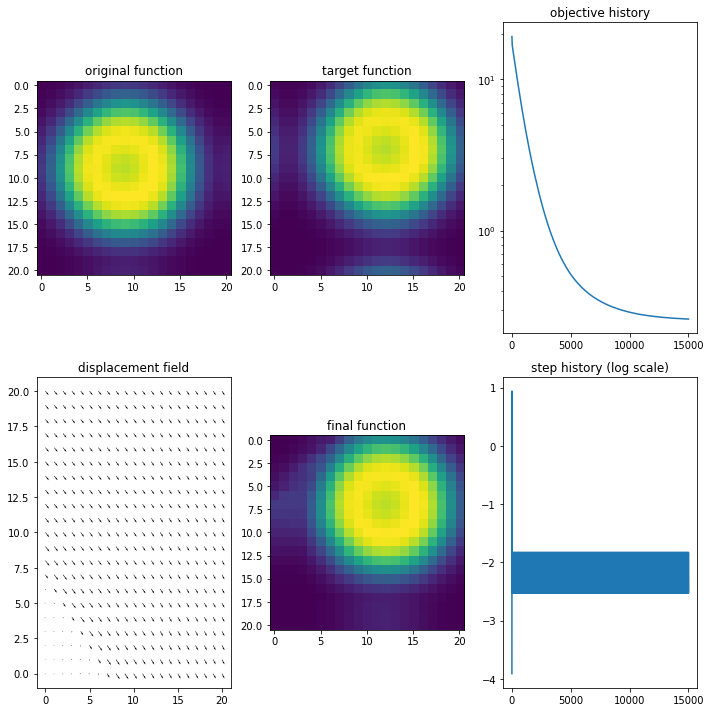

In [23]:
u, CF, step = results(f,g,15000,1e-2,1,1)
plot_results(f,g,u,CF,step)

Graphiquement, on voit que l'allure de la fonction retrouvée en composant $f$ avec $(id+u^{\textrm{final}})$ semble bien restituer celle de la fonction décalée originale. Le champ de déplacement est raisonnable en ce qu'il semble très régulier et est proche de celui d'une translation (au dehors d'un coin sans déplacements). Après 15 000 itérations, la fonction objectif a beaucoup diminué et ne varie plus beaucoup (entre 0,270 et 0,260 au cours des 2700 dernières itérations). Après quelques itérations, le pas alterne entre deux valeurs, 0.08 et 0.16.

En dépit de ce que la fonction d'origine semble être bien restituée, et le champ de déplacement raisonnable, le nombre d'itération paraît très important pour un problème si simple (et de dimension relativement faible).

Essayons quelques autres pas initiaux.

In [27]:
# u, CF, step = results(f,g,15000,1,1,1)
# #plot_results(f,g,u,CF,step)
# print(step[-1000:-950])
# print(CF[-1])

In [28]:
# u, CF, step = results(f,g,15000,1e-5,1,1)
# #plot_results(f,g,u,CF,step)
# print(step[-1000:-950])
# print(CF[-1])

In [29]:
# u, CF, step = results(f,g,15000,1e-7,1,1)
# #plot_results(f,g,u,CF,step)
# print(step[-1000:-950])
# print(CF[-1])

Graphiquement (on a retiré les plots pour plus de lisibilité), on ne parvient pas à distinguer les résultats, autant en ce qui concerne la fonction retrouvée avec $u^{\textrm{final}}$, que l'allure du champ de déplacements (toujours proche de celui d'une translation / au dehors d'un coin presque sans déplacements), ou l'évolution de la fonction coût. Dans tous les cas, sa valeur finale est proche de 0,26. Enfin, les pas choisis par la recherche linéaire sont différents, mais le comportement reste qualitativement le même : une courte phase au cours de laquelle les pas varient beaucoup, puis ils alternent plus qu'entre deux valeurs.

Cette faible sensibilité au pas initial, pourvu qu'il ne soit pas aberrant, était un résultat attendu en raison de la recherche linéaire de pas à chaque itération de l'algorithme de gradient.

On décide de ne pas étudier davantage l'impact du pas initial.

Intéressons-nous désormais aux paramètres (les "constantes de Lamé") du terme de régularisation R.
$$
R(u)= \frac{\mu}{2}\sum_{i}(\partial_x u_y + \partial_y u_x)^2(i) + \frac{\lambda+\mu}{2} \sum_i(\partial_x u_x + \partial_y u_y)^2(i).
$$
Le paramètre $\mu$, analogue au module de cisaillement, pondère en effet l'importante de la pénalsation sur le cisaillement du champ de déplacement ; tandis que les paramètres $\lambda$ et $\mu$ pondèrent conjointement l'importance de la pénalisation sur la compression du champ de déplacement (on le voit immédiatement dans la formule). On peut d'ailleurs s'en rendre compte graphiquement sur quelques exemples, à travers l'effet qu'a le choix de ces paramètres sur l'allure du champ de déformation obtenu.

Pour commencer, en l'absence de régularisation, on obtient certes une bonne restitution de la fonction décalée - ce qui n'est pas forcement notre objectif final dans un problème réel - cependant on l'obtient par l'intermédiaire d'un champ de déplacement déraisonnable (en ce qu'il semble peu régulier, et est surtout très éloigné d'une translation qui est vraisemblablement "le bon" champ de déplacement - le plus naturel en l'absence d'autres informations car le plus simple).

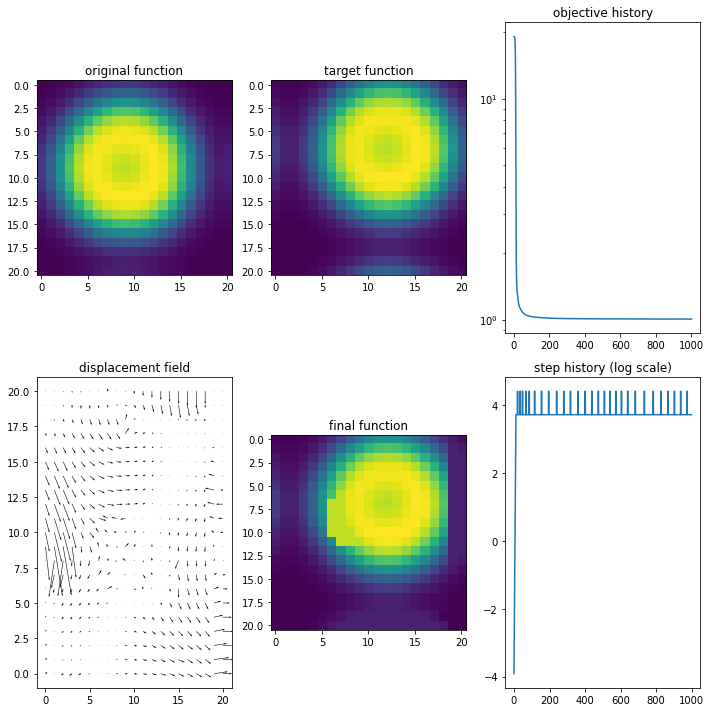

In [31]:
u, CF, step = results(f,g,1000,1e-2,0,0)
plot_results(f,g,u,CF,step)

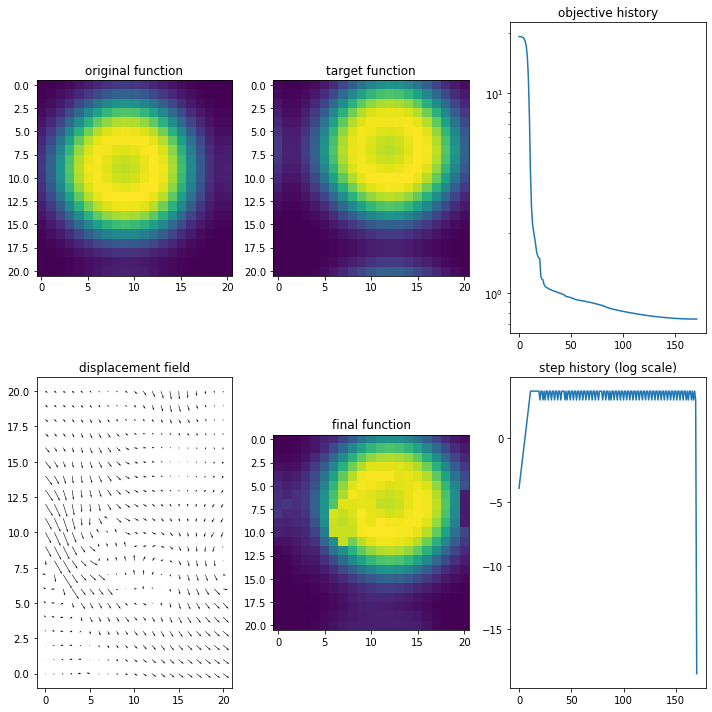

In [32]:
u, CF, step = results(f,g,1000,1e-2,.001,.001)
plot_results(f,g,u,CF,step)

Remarquons qu'avec $\lambda=\mu=0,01$, on obtient déjà des résultats qualitativement comparables - concernant l'allure du champ de déplacements, à ceux obtenus avec $\lambda=\mu=1$.

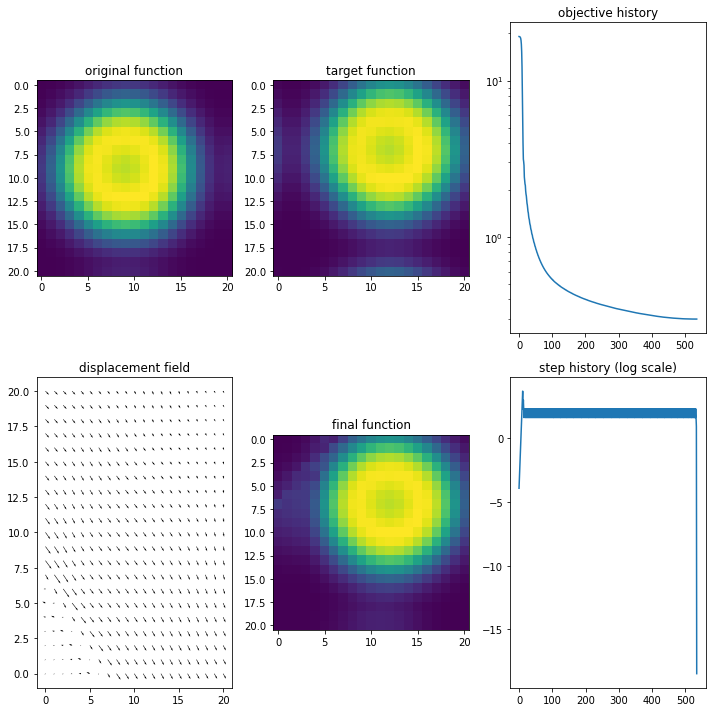

In [33]:
u, CF, step = results(f,g,1000,1e-2,.01,.01)
plot_results(f,g,u,CF,step)

In [21]:
print(len(CF))
CF[-1]

536


0.29892992484860326

Avec $\mu=\lambda=0,1$, l'algorithme du gradient converge en 535 itérations, pour atteindre une valeur de 0.299 pour la fonction coût. On utilisera ces valeurs comme référence pour la comparaison avec l'algorithme des moindres carrés.

Intéressons nous aux rôles respectifs des deux "coefficients de Lamé". 

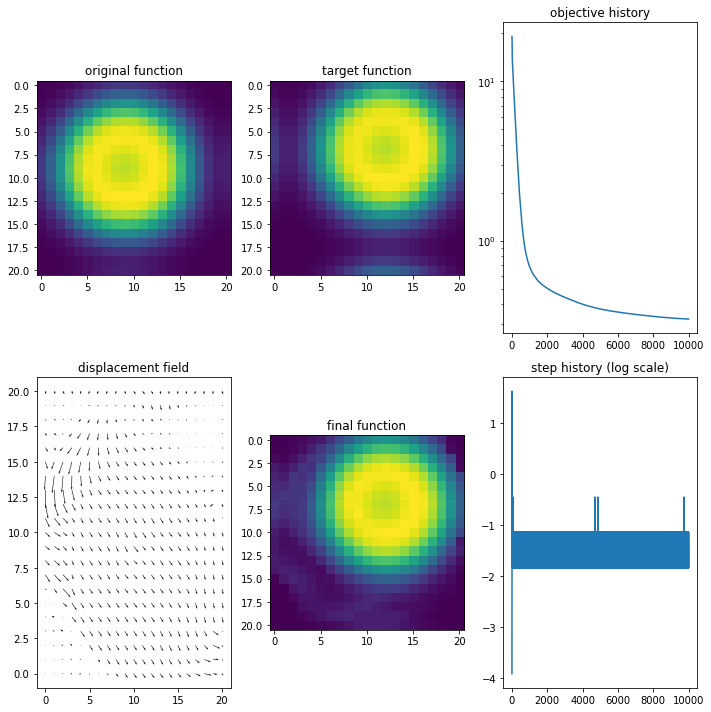

In [34]:
u, CF, step = results(f,g,10000,1e-2,1,0)
plot_results(f,g,u,CF,step)

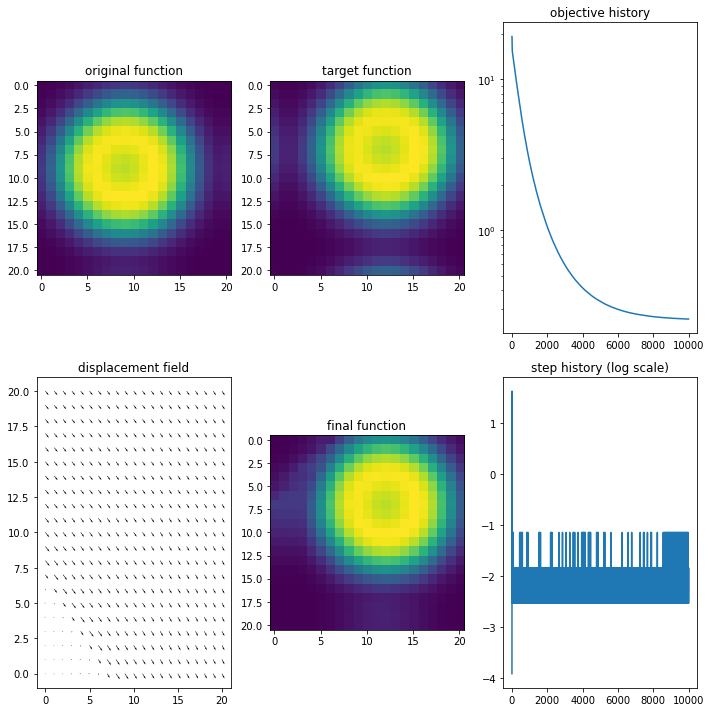

In [35]:
u, CF, step = results(f,g,10000,1e-2,0,1)
plot_results(f,g,u,CF,step)

On voit que l'action de la pénalisation sur le cisaillement semble plus importante (pertinente) dans cette situation où l'objet représenté sur l'image cible est peu sinon pas déformé, que l'action de la pénalisation sur la compression. Toutefois il convient de remarquer que pour $\lambda=0$, un $\mu$ non nul donne une égale importance à $R_1(u)$ et $R_2(u)$, ce qui peut aussi expliquer que le champ de déplacement parait plus raisonnable en mettant $\lambda$ à $0$ qu'en mettant $\mu$ à $0$.

Notons enfin qu'en accordant trop d'importance au terme de régularisation $R$, la quantité $E(u)$ serait peu minimisée (pas suffisamment - ou en un nombre d'itérations beaucoup plus grand que dans les tests précédents) car les directions de descente de $E+R$ seraient "trop dictées" par celles de $R$. Il en résulterait que le champ de déplacement $u$ répondrait très mal à notre problème, comme on le voit ci-dessous.

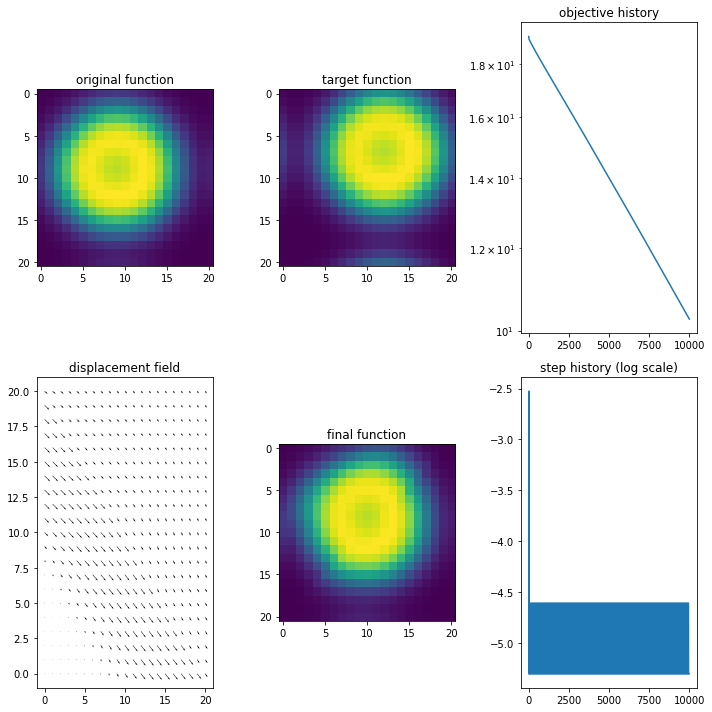

In [36]:
u, CF, step = results(f,g,10000,1e-2,10,20)
plot_results(f,g,u,CF,step)

Retenons, pour comparaison avec l'algorithme des moindres carrés, qu'avec $\lambda=10,\, \mu=20$ l'algorithme de gradient n'a pas convergé après 10 000 itérations.

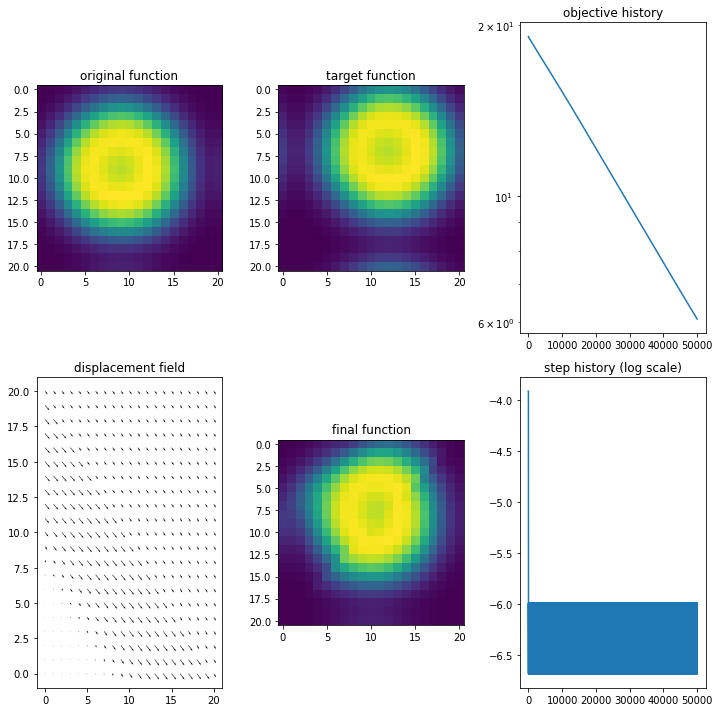

In [37]:
u, CF, step = results(f,g,50000,1e-2,50,50)
plot_results(f,g,u,CF,step)

Enfin, notons qu'en pratique, nous pourrions évidemment choisir les coefficients $\lambda$ et $\mu$ en réitérant dans une boucle les calculs avec différentes valeurs pour ces coefficients, de sorte à pouvoir tracer l'évolution d'un critère qui nous intéresse en fonction de ces valeurs. Par exemple : nb. d'itérations min. en fonction de $\mu$ pour atteindre une certaine valeur de $E(u)$, valeur de $E(u)$ en fonction de $\mu$ ou $\lambda$ à nb. d'itérations fixé, etc ; ou encore, valeur de la pénalisation à nb. d'itération max. et loss finale. max. fixés...

Dans la présente situation, en l'absence d'objectifs, ce n'est pas réellement nécessaire. A titre informatif, voici tout de même l'évolution de la valeur finale de la fonction objectif, selon les valeurs de $\lambda$ à $\mu$ fixé, et réciproquement (si nécessaire, on aurait pû tracer l'évolution en fonction des deux paramètres, en 3D) :

In [40]:
(lams, costs, iterations) = obj_vs_lam(f, g, lowerbound=-4, upperbound=1, lam=None, mu=0, nitermax=15000, N_points=20, algo=1)

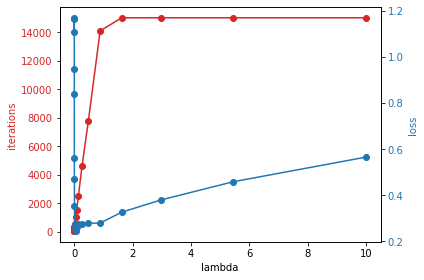

In [41]:
plot_curves("lambda", lams, iterations, costs)

Rappelons que le nb. d'itérations max était fixé à 15 000 (le "plafond" sur la courbe rouge correspond aux lambda pour lesquels l'algorithme n'avait pas encore convergé à 15 000 itérations).

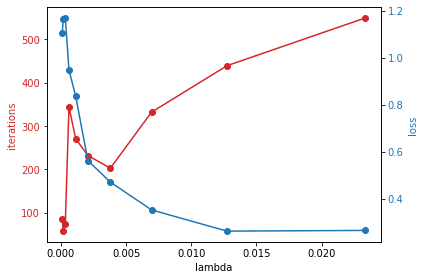

In [42]:
plot_curves("lambda", lams[:10], iterations[:10], costs[:10])

In [92]:
# (mu_list, costs, iterations) = obj_vs_lam(f,g,lowerbound=-4, upperbound=1, lam=0, mu=None, nitermax=15000, N_points=20, algo=1)
# plot_curves("mu", mu_list, iterations, costs)

In [93]:
# plot_curves("mu", mu_list[:10], iterations[:10], costs[:10])

In [46]:
(lams, costs, iterations) = obj_vs_lam(f,g,lowerbound=-4, upperbound=0, lam=None, mu=0.05, nitermax=5000, N_points=30, algo=1)

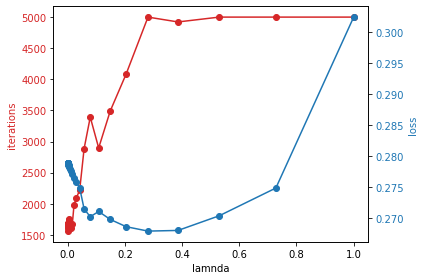

In [47]:
plot_curves("lamnda", lams, iterations, costs)

## 4. Algorithme de moindres carrés.

On souhaite maintenant implémenter un algorithme de second ordre pour résoudre le problème $(P)\quad\min_u E(u)+R(u)$ afin d'accélérer la convergence de l'algorithme. Pour cela, on va reformuler le problème $(P)$ en un problème de moindres carrés et appliquer l'algorithme de Levenberg-Marquardt.

Soit:
$$\Psi(u)=\begin{pmatrix} 
f\circ(Id+u)-g \\ 
\sqrt{\mu}(\partial_xu_y+\partial_yu_x) \\ 
\sqrt{\mu+\lambda}(\partial_xu_x+\partial_yu_y) \end{pmatrix},$$
où $f\circ(id+u)$ est l'interpolation de $x\mapsto f(x+u(x))$ sur la grille. Minimiser $E(u)+R(u)$ est équivalent à résoudre le problème suivant :

> $$\min_u \|\Psi(u)\|_2^2.$$

Il s'agit maintenant d'un problème de moindres carrés que l'on va résoudre à l'aide de l'algorithme de Levenberg Marquardt :

$$
u_{k+1}=u_k- H_k^{-1} J_{\Psi}(u_k)^\top \Psi(u_k) \quad \textrm{ avec }\quad H_k=J_{\Psi}(u_k)^\top J_{\Psi}(u_k) +\varepsilon Id
$$

La matrice jacobienne de $\Psi$ est donnée par :

$$
\overline{\nabla}\Psi(u) \overset{\Delta}{=} J_\Psi(u) \overset{\Delta}{=}
\begin{pmatrix}
\overline{\nabla}\Psi_1 \\
\overline{\nabla}\Psi_2 \\
\overline{\nabla}\Psi_3
\end{pmatrix}(u)
\overset{\Delta}{=} \begin{pmatrix}
\left(\vec{\nabla}\Psi_1\right)^T \\
\left(\vec{\nabla}\Psi_2\right)^T \\
\left(\vec{\nabla}\Psi_3\right)^T
\end{pmatrix}(u)
=
\begin{pmatrix}
(\nabla f\circ(I+u))^T \\
\sqrt{\mu}B_1 \\
\sqrt{\mu+\lambda}B_2
\end{pmatrix}
$$
avec $B_1=(\partial_y\quad\partial_x)$ et $B_2=(\partial_x\quad\partial_y)$.

La classe `MoindreCarres` prend en argument à l'initialisation les fonctions `E` et `R`. A l'initialisation, elle crée une instance de la classe `objectif` qu'elle met dans la variable `self.obj`. Ainsi on peut retrouver la fonction coût en appelant la fonction `self.obj.eval()`.
Cette classe comporte les fonctions `compute(u)`, `JPsi(u,h)`,`JPsiT(u,phi)`,`LM(u,h,epsilon)` qui calculent respectivement

- Le vecteur $\Psi(u)$
- le produit de $J_\psi(u)$ par une direction $h=(h_x,h_y)\in V^2$,
- le produit de $J_\Psi(u)^\top$ par $\phi=(\phi_1,\phi_2,\phi_3)\in V^3$,
- le produit de $(J_\Psi(u)^\top J_\Psi(u)+\epsilon I)$ par une direction $h=(h_x,h_y)\in V^2$.

On réalise les différents tests ci-dessous :

In [55]:
# definition des produits scalaires

# Création des problèmes
r=lib.R(lam=10,mu=0)
e=lib.E(f,g)
MC=lib.MoindreCarres(e,r)
np.random.seed(42)
u=(np.random.randn(nx,ny),np.random.randn(nx,ny))
tmp=MC.compute(u)
print(MC.obj.eval(u),0.5*lib.produit2(tmp,tmp))

# test de la transposée de la jacobienne de J
h=(np.random.randn(nx,ny),np.random.randn(nx,ny))
psi=(np.random.randn(nx,ny),np.random.randn(nx,ny),np.random.randn(nx,ny))
psi1=MC.JPsi(u,h)
h1=MC.JPsiT(u,psi)
print(lib.produit1(h,h1),lib.produit2(psi,psi1))

# test de la matrice 
r=MC.LM(u,h,epsilon=1.e3)
print(lib.produit1(r,h))

8741.724838697673 8741.724838697679
-8.421286300079402 -8.42128630007937
900512.3254249495


Calculons maintenant la direction de recherche $d_k$ comme solution du système linéaire :
$$(J_\Psi(u_k)^\top J_\Psi(u_k) +\epsilon I)\left(\begin{array}{c}
d_x\\
d_y
\end{array}\right) = -J_\Psi(u_k)^\top \Psi(u_k)$$
On utilise un algorithme de gradient conjugué qui calcule une solution $d=(d_x,d_y)\in V^2$ du problème:
$$(J_\Psi(u)^\top J_\Psi(u) +\epsilon I)\left(\begin{array}{c}
d_x\\
d_y
\end{array}\right) = b$$

### Première partie : tests sans changer la valeur de $\epsilon$

In [57]:
epsi=0.1
nitermax=1000
u,CF,step=lib.RecalageGN(MC,nitermax,epsi)
print(len(CF)-1, "iterations")

260 iterations


Avec `epsi=0.1`, `lam=10` et `mu=0`, l'algorithme des moindres carrés converge en 260 itérations.

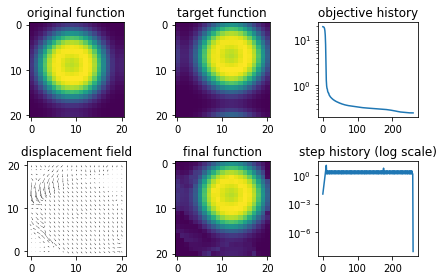

In [58]:
fig, ax = plt.subplots(2,3)
ax[0,0].imshow(f)
ax[0,0].set_title('original function')
ax[0,1].imshow(g)
ax[0,1].set_title('target function')
(ux,uy)=u
ax[1,0].quiver(ux,uy)
ax[1,0].set_title('displacement field')
ax[1,1].imshow(lib.interpol(f,u))
ax[1,1].set_title('final function')
ax[0,2].semilogy(CF)
ax[0,2].set_title('objective history')
ax[1,2].semilogy(step)
ax[1,2].set_title('step history (log scale)')

plt.tight_layout()
plt.show()

On essaye avec les $\mu=\lambda=0,1$, valeurs pour lesquelles on avait convergence en 535 itérations pour une loss de 0.299 avec l'algorithme du gradient.

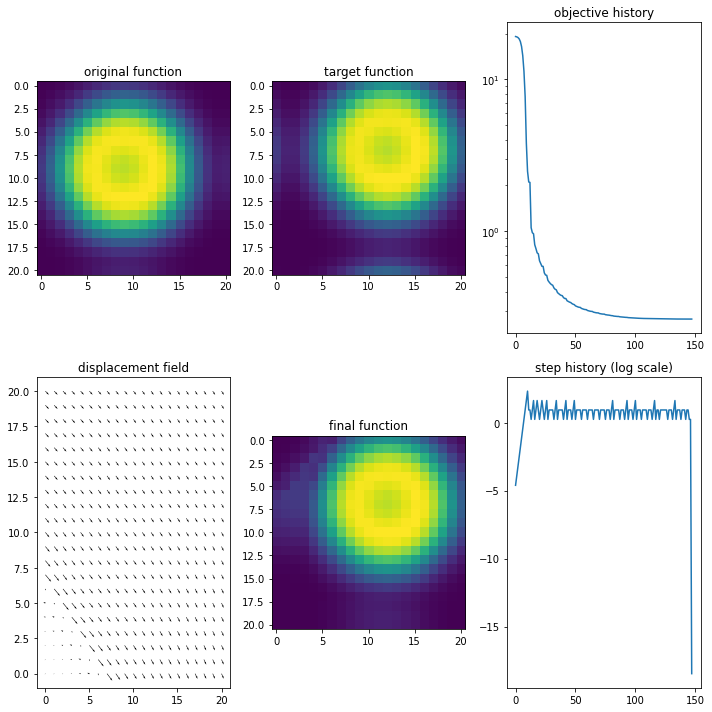

In [61]:
r=lib.R(lam=.1,mu=.1)
e=lib.E(f,g)
MC=lib.MoindreCarres(e,r)
u,CF,step=lib.RecalageGN(MC,nitermax,epsi)
plot_results(f,g,u,CF,step)

In [62]:
print(len(CF)-1, "iterations")
CF[-1]

147 iterations


0.2638399712770235

L'algorithme des moindres carrés converge en 147 itérations pour ces pramètres, contre 535 itérations avec l'algorithme du gradient, et atteint une loss de 0,264 contre 0.299 pour l'algorithme du gradient. Notons d'ailleurs qu'il s'agit d'une situation très favorable à l'algorithme du gradient, qui, dans les autres cas testés, ne convergeait pas même en 10 000 itérations, alors qu'on va voir que l'algorithme des moindres carrés continue à converger  dans la plupart des situations en ~10 à ~200 itérations.

Testons aussi d'autres paramètres. Notons qu'on a ajouté $\epsilon I$ avec $\epsilon=0.1$ jusqu'à maintenant à $J_\Psi(u)^\top J_\Psi(u)$, afin d'éviter que la matrice soit singulière. Cette valeur est très élevée, et on obtient de bien meilleures performances avec un $\textrm{epsi}$ plus petit (voire nul !) - comme on le vérifie dans la suite.

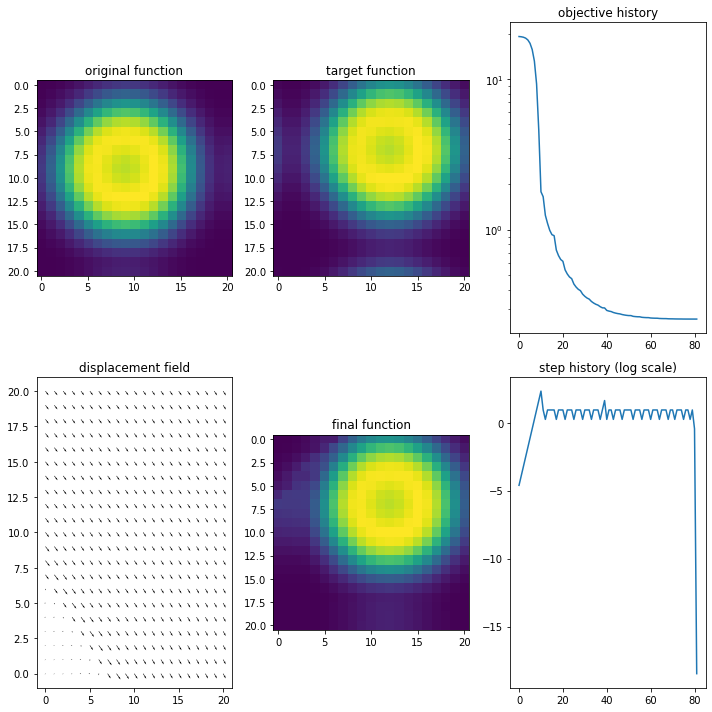

In [63]:
r=lib.R(lam=.1,mu=1)
e=lib.E(f,g)
MC=lib.MoindreCarres(e,r)
u,CF,step=lib.RecalageGN(MC,nitermax,epsi)
plot_results(f,g,u,CF,step)

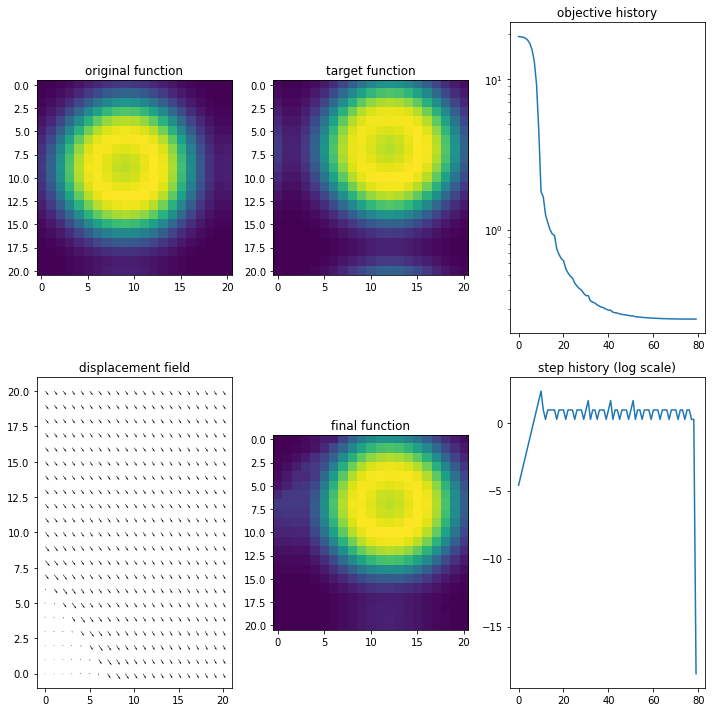

In [64]:
r=lib.R(lam=0,mu=1)
e=lib.E(f,g)
MC=lib.MoindreCarres(e,r)
u,CF,step=lib.RecalageGN(MC,nitermax,epsi)
plot_results(f,g,u,CF,step)

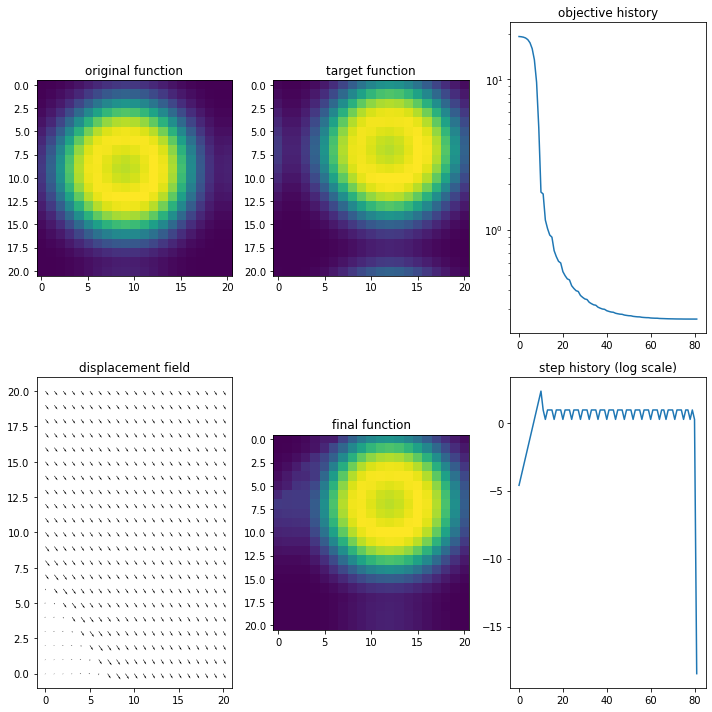

In [65]:
r=lib.R(lam=1,mu=1)
e=lib.E(f,g)
MC=lib.MoindreCarres(e,r)
u,CF,step=lib.RecalageGN(MC,nitermax,epsi)
plot_results(f,g,u,CF,step)

In [66]:
len(CF)
CF[-1]

0.2557814916077015

Rappelons que pour ces paramètres, l'algorithme du gradient avait atteint la valeur de 0.258 pour la fonction objectif, après 15 000 itérations.

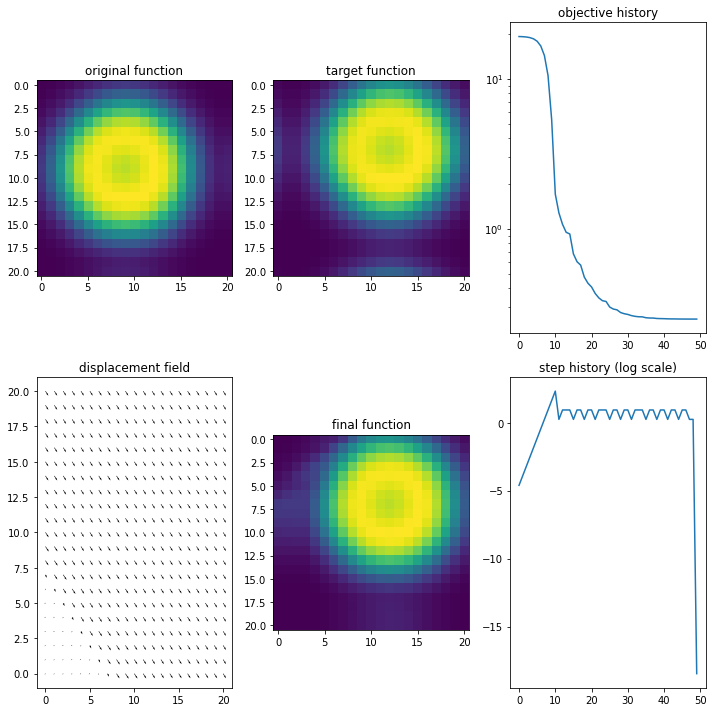

In [67]:
r=lib.R(lam=10,mu=10)
e=lib.E(f,g)
MC=lib.MoindreCarres(e,r)
u,CF,step=lib.RecalageGN(MC,nitermax,epsi)
plot_results(f,g,u,CF,step)

In [68]:
len(CF)

50

Convergence en 49 itérations !

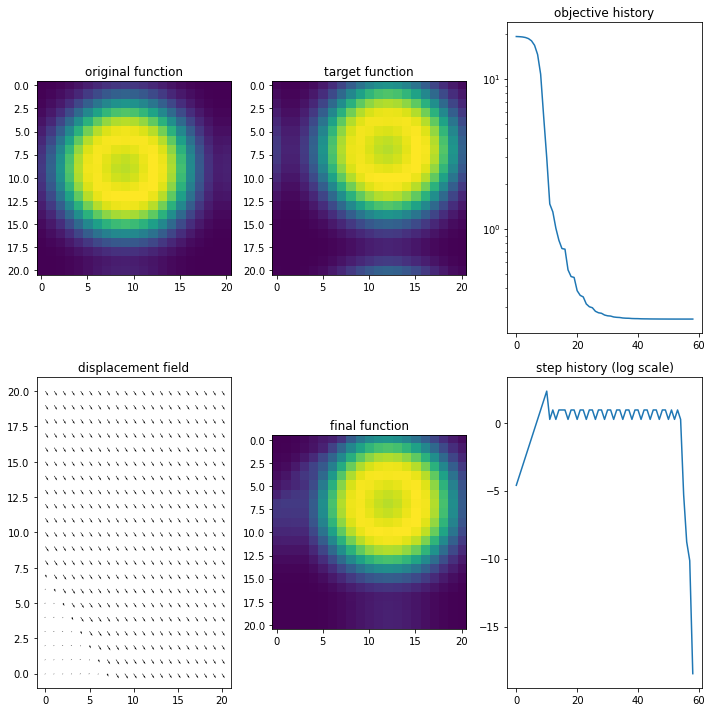

In [69]:
r=lib.R(lam=50,mu=50)
e=lib.E(f,g)
MC=lib.MoindreCarres(e,r)
u,CF,step=lib.RecalageGN(MC,nitermax,epsi)
plot_results(f,g,u,CF,step)

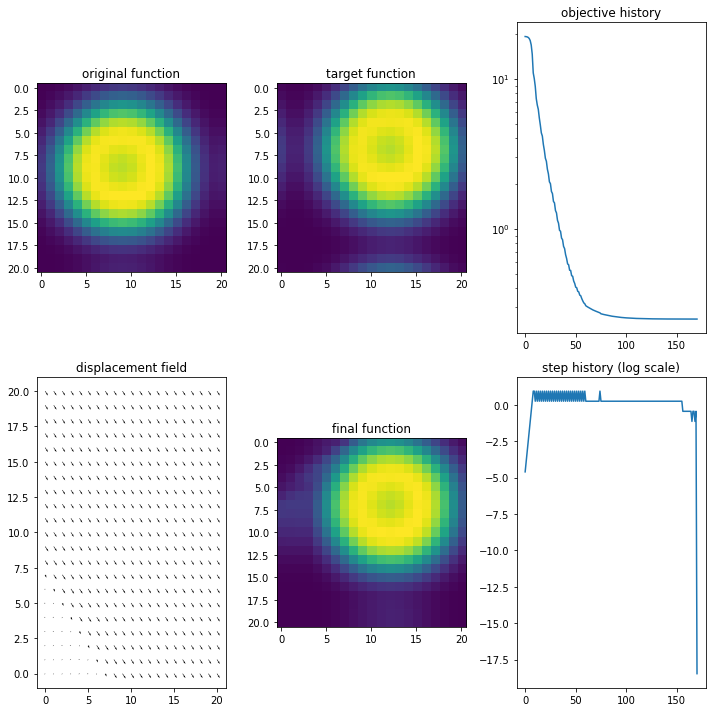

In [70]:
r=lib.R(lam=200,mu=200)
e=lib.E(f,g)
MC=lib.MoindreCarres(e,r)
u,CF,step=lib.RecalageGN(MC,nitermax,epsi)
plot_results(f,g,u,CF,step)

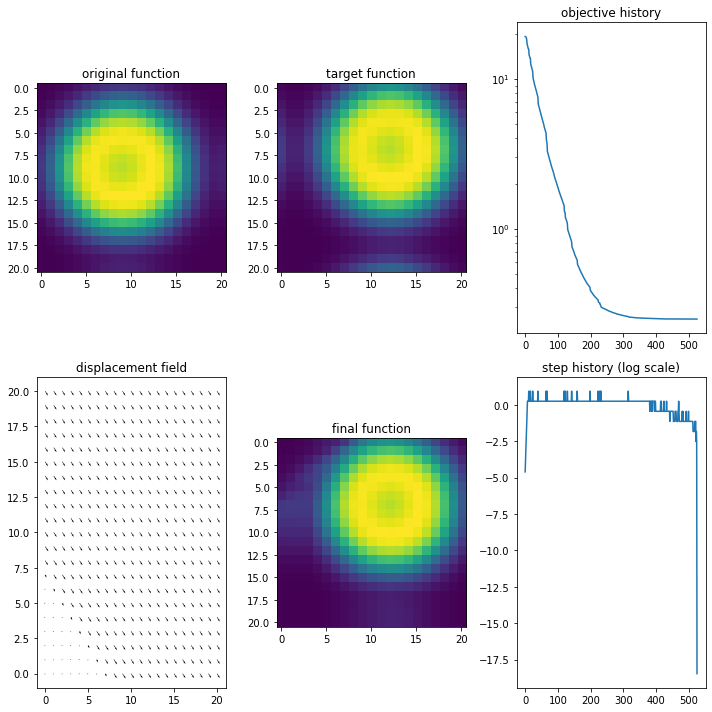

In [71]:
r=lib.R(lam=200,mu=1000)
e=lib.E(f,g)
MC=lib.MoindreCarres(e,r)
u,CF,step=lib.RecalageGN(MC,nitermax,epsi)
plot_results(f,g,u,CF,step)

### Deuxième partie : tests avec de nouvelles valeurs pour $\epsilon$

Par soucis de lisibilité, on a affiche seulement le résultat de quelques uns des tests. D'autres sont proposés en commentaire.

On retiendra qu'avec $\epsilon$ compris entre $0$ et $10^{-3}$, et des valeurs de l'ordre de $10^{-2}$ à $1$, l'algorithme converge en 10 à 20 itérations. On se doit cependant de préciser que le champ de déplacement obtenu est moins satisfaisant pour de très petites valeurs de $\mu$ et $\lambda$ ($<0.1$).

Remarquons enfin qu'avec l'algorithme des moindres carrées, des valeurs beaucoup plus grande ($10, 100$) n'empêchent pas la convergence (en 17 et 93 itérations respectivement), et assurent de manière plus robuste que le champ de déplacement est aussi régulier qu'on l'espère.

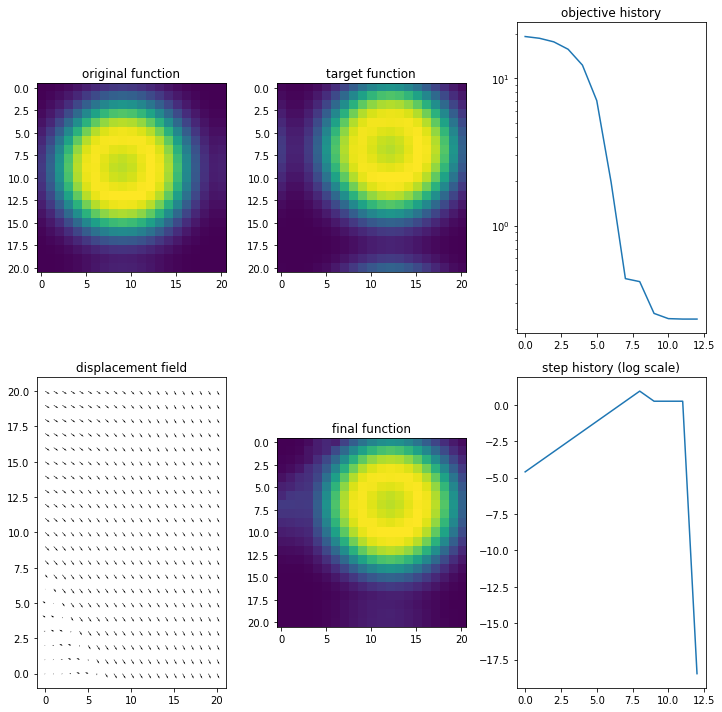

In [72]:
epsi = 1e-3
r=lib.R(lam=0.1,mu=0.01) # 12 iterations avec epsi=10e-3.

#epsi = 0
#r=lib.R(lam=0.01,mu=0.1) # 10 iterations avec epsi=0, 12 avec epsi=1e-3
#r=lib.R(lam=0.1,mu=0.01) # 11 iterations avec epsi=0, 12 avec epsi=1e-3
#r=lib.R(lam=0.01,mu=0.01) # 10 iterations avec epsi=0, 13 avec epsi=1e-3
#r=lib.R(lam=0.001,mu=0.01) # 11 iterations avec epsi=0, 14 avec epsi=1e-3
e=lib.E(f,g)
MC=lib.MoindreCarres(e,r)
u,CF,step=lib.RecalageGN(MC,nitermax,epsi)
plot_results(f,g,u,CF,step)

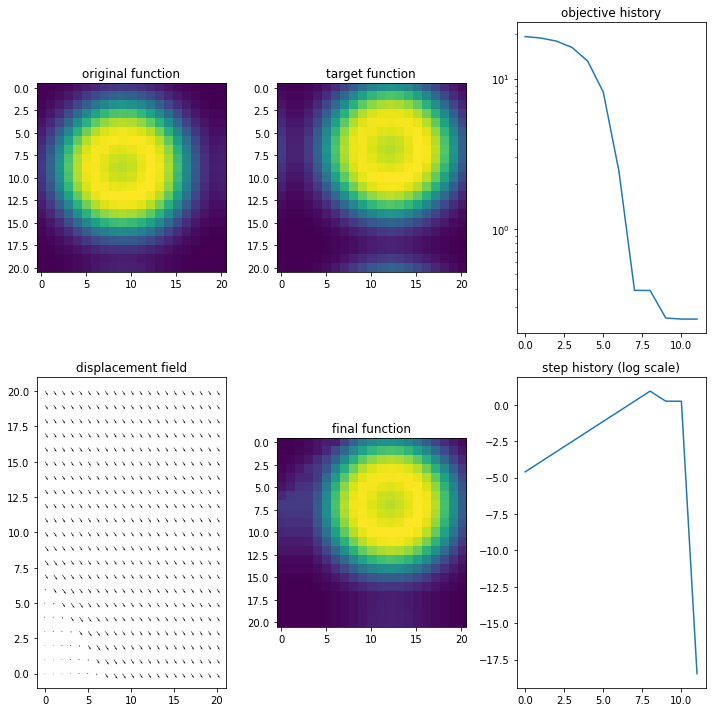

In [73]:
epsi = 1e-3
r=lib.R(lam=1,mu=1)
e=lib.E(f,g)
MC=lib.MoindreCarres(e,r)
u,CF,step=lib.RecalageGN(MC,nitermax,epsi)
plot_results(f,g,u,CF,step)

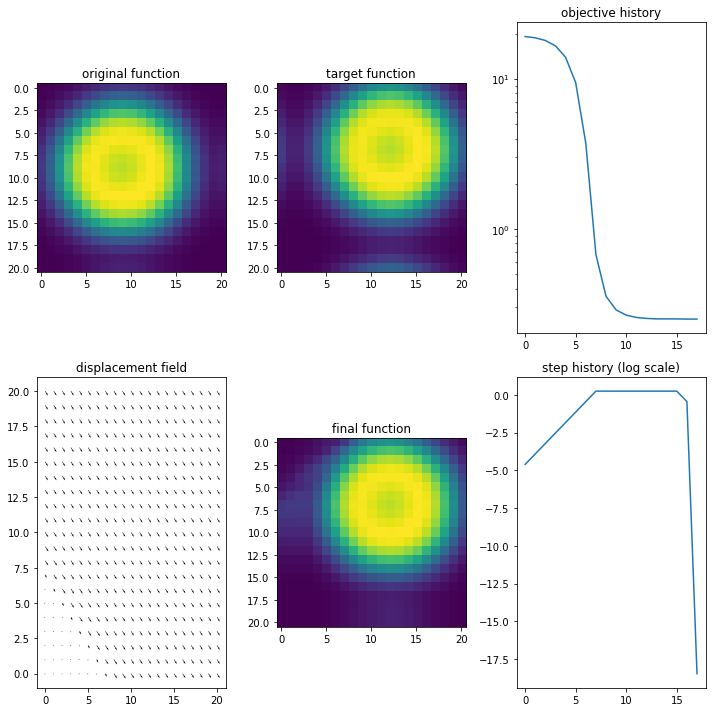

In [74]:
epsi = 1e-3
r=lib.R(lam=10,mu=10)
e=lib.E(f,g)
MC=lib.MoindreCarres(e,r)
u,CF,step=lib.RecalageGN(MC,nitermax,epsi)
plot_results(f,g,u,CF,step)

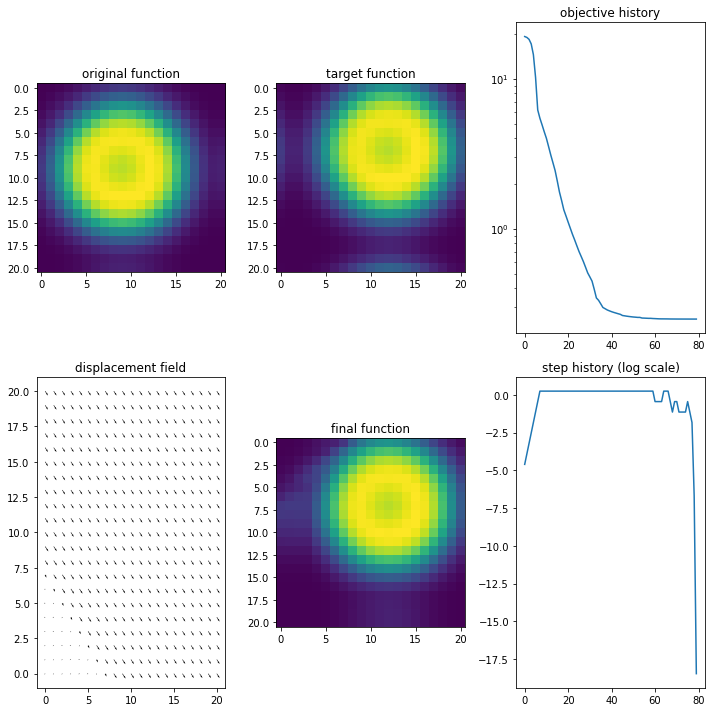

In [75]:
epsi = 1e-3
r=lib.R(lam=100,mu=100)
e=lib.E(f,g)
MC=lib.MoindreCarres(e,r)
u,CF,step=lib.RecalageGN(MC,nitermax,epsi)
plot_results(f,g,u,CF,step)

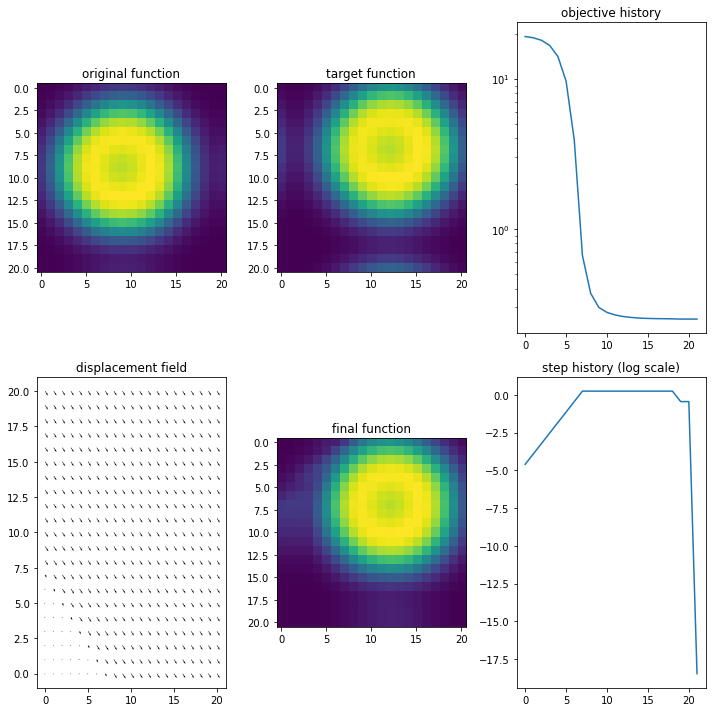

In [76]:
epsi = 1e-3
r=lib.R(lam=10,mu=20)
e=lib.E(f,g)
MC=lib.MoindreCarres(e,r)
u,CF,step=lib.RecalageGN(MC,nitermax,epsi)
plot_results(f,g,u,CF,step)

L'algorithme des moindres carrés a convergé en 21 itérations et atteint une perte de 0.250 pour $\lambda=10, \mu=20$, là où l'algorithme de gradient n'avait pas convergé (ni conduit à un recalage satisfaisant visuellement) même au bout de 10 000 itérations.

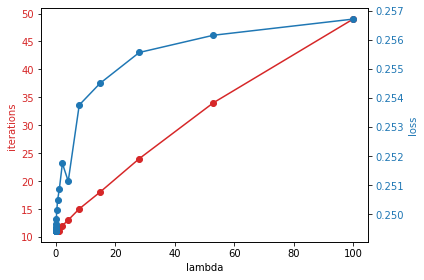

In [78]:
(lams, costs, iterations) = obj_vs_lam(f,g,lowerbound=-6,upperbound=2, lam=None, mu=1, nitermax=1000, N_points=30, algo=2, epsi=1e-3)
plot_curves("lambda", lams, iterations, costs)

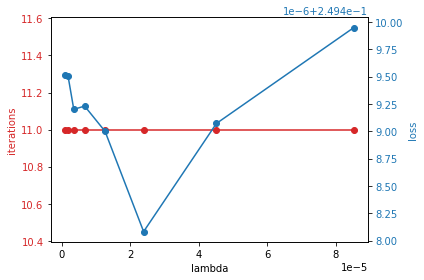

In [79]:
plot_curves("lambda", lams[:8], iterations[:8], costs[:8])

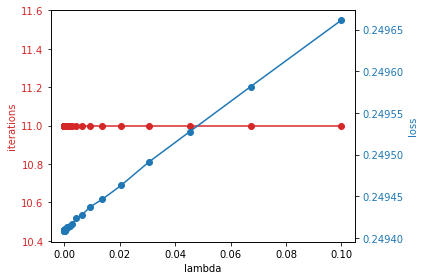

In [80]:
(lams, costs, iterations) = obj_vs_lam(f,g,lowerbound=-6,upperbound=-1, lam=None, mu=1, nitermax=1000, N_points=30, algo=2, epsi=1e-3)
plot_curves("lambda", lams, iterations, costs)

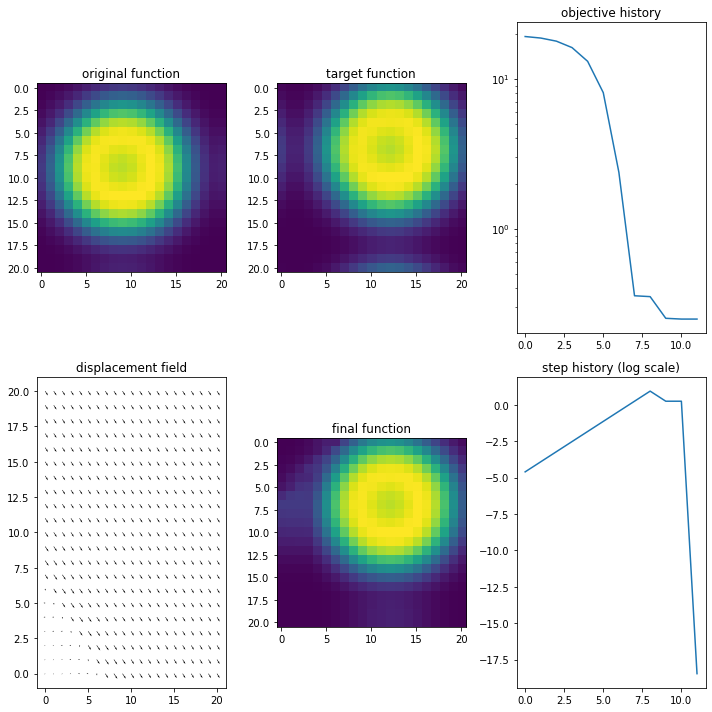

In [81]:
epsi = 1e-3
r=lib.R(lam=1e-6,mu=1)
e=lib.E(f,g)
MC=lib.MoindreCarres(e,r)
u,CF,step=lib.RecalageGN(MC,nitermax,epsi)
plot_results(f,g,u,CF,step)